In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import train_test_split
#from sklearn.svm import SVC
from cuml.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")


from sklearn import set_config

set_config(display="diagram")

In [2]:
#Original
features_ALL_IDB2 = np.load('../input/pca-pretraining-featureextraction-resnet-all-idb2/ALL_IDB2_ExtractedFeatures.npy')
labels_ALL_IDB2 = np.load('../input/pca-pretraining-featureextraction-resnet-all-idb2/Targets.npy')
labels_ALL_IDB2 = [np.argmax(y, axis=None, out=None) for y in labels_ALL_IDB2]
labels_ALL_IDB2 = np.asarray(labels_ALL_IDB2)

#Jaya
featuresIndex_ALL_IDB2_Jaya_100iter = np.load('../input/featureselection-jaya-all-idb2/SelectedFeaturesIndexs_ALL_IDB2_ResNet_100iter.npy')
features_ALL_IDB2_Jaya_100iter = features_ALL_IDB2[:, featuresIndex_ALL_IDB2_Jaya_100iter]

print("Features Jaya ALL-IDB2 100iter Shape: ", features_ALL_IDB2_Jaya_100iter.shape)
print("Labels ALL-IDB2 Shape: ", labels_ALL_IDB2.shape)

Features Jaya ALL-IDB2 100iter Shape:  (2004, 959)
Labels ALL-IDB2 Shape:  (2004,)


 ### **SVM Classification**

Fold :  1  Accuracy:  0.9970059880239521  Precision:  0.9935064935064936  Recall:  1.0  F1-Score:  0.9967426710097721  AUC:  0.9972375690607735
---------------------------------------------------------
Fold :  2  Accuracy:  0.9985029940119761  Precision:  0.9965986394557823  Recall:  1.0  F1-Score:  0.9982964224872232  AUC:  0.9986666666666666
---------------------------------------------------------
Fold :  3  Accuracy:  0.9880239520958084  Precision:  0.9749216300940439  Recall:  1.0  F1-Score:  0.9873015873015873  AUC:  0.9887955182072828
---------------------------------------------------------


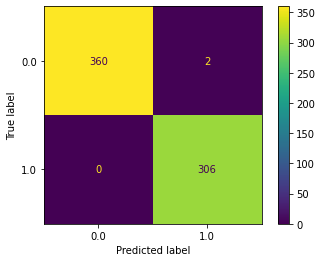

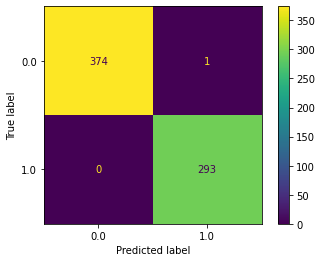

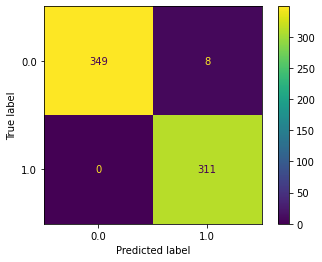

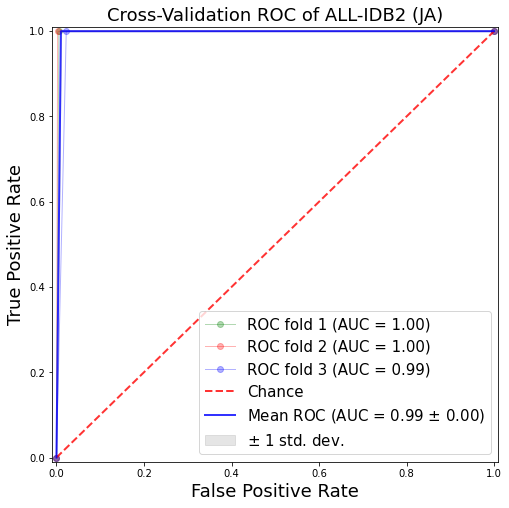

In [3]:
tprs = []
aucs = []
fprs = []
# Define per-fold score containers <-- these are new
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1score_per_fold = []
num_folds = 3
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(features_ALL_IDB2_Jaya_100iter, labels_ALL_IDB2):
    clf = None
    clf = SVC(kernel='rbf', C=0.1, gamma=0.0001, random_state=0)
    clf.fit(features_ALL_IDB2_Jaya_100iter[train], labels_ALL_IDB2[train])
    preds = clf.predict(features_ALL_IDB2_Jaya_100iter[test])
    precision = precision_score(labels_ALL_IDB2[test], preds)
    recall = recall_score(labels_ALL_IDB2[test], preds)
    accuracy = accuracy_score(labels_ALL_IDB2[test], preds)
    f1 = f1_score(labels_ALL_IDB2[test], preds)
    fpr, tpr, thresholds = roc_curve(labels_ALL_IDB2[test], preds)
    auc_fold = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(auc_fold)
    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1score_per_fold.append(f1)
    print("Fold : ", fold_no, " Accuracy: ", accuracy, " Precision: ", precision, " Recall: ", recall, " F1-Score: ", f1, " AUC: ", auc_fold)
    _ = plot_confusion_matrix(clf, features_ALL_IDB2_Jaya_100iter[test], labels_ALL_IDB2[test])
    print("---------------------------------------------------------")
    fold_no = fold_no + 1

cv3_results_JA_ALL_IDB2_100iter = pd.DataFrame(data={"Accuracy": accuracy_per_fold, "Precision": precision_per_fold, "Recall": recall_per_fold, "F1-Score": f1score_per_fold, " AUC": aucs})
cv3_results_JA_ALL_IDB2_100iter.to_csv("./cv3_results_JA_ALL_IDB2_100iter.csv")
cv3_results_JA_ALL_IDB2_100iter.head()

plt.figure(figsize=(8,8))
plt.plot(fprs[0], tprs[0], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[0]))
plt.plot(fprs[1], tprs[1], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[1]))
plt.plot(fprs[2], tprs[2], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[2]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of ALL-IDB2 (JA)',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

Fold :  1  Accuracy:  0.9925187032418953  Precision:  0.9835164835164835  Recall:  1.0  F1-Score:  0.9916897506925207  AUC:  0.9932432432432433
---------------------------------------------------------
Fold :  2  Accuracy:  0.9950124688279302  Precision:  0.9885714285714285  Recall:  1.0  F1-Score:  0.9942528735632185  AUC:  0.9956140350877193
---------------------------------------------------------
Fold :  3  Accuracy:  0.9925187032418953  Precision:  0.9895287958115183  Recall:  0.9947368421052631  F1-Score:  0.9921259842519685  AUC:  0.9926290845597406
---------------------------------------------------------
Fold :  4  Accuracy:  1.0  Precision:  1.0  Recall:  1.0  F1-Score:  1.0  AUC:  1.0
---------------------------------------------------------
Fold :  5  Accuracy:  0.995  Precision:  0.9891304347826086  Recall:  1.0  F1-Score:  0.994535519125683  AUC:  0.9954128440366973
---------------------------------------------------------


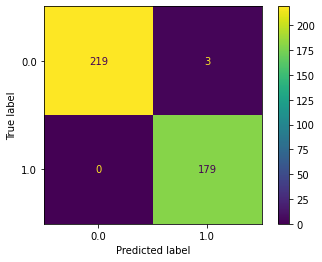

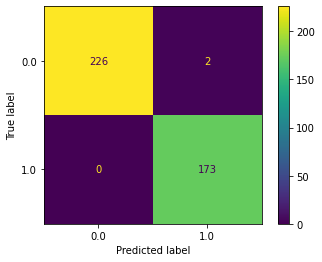

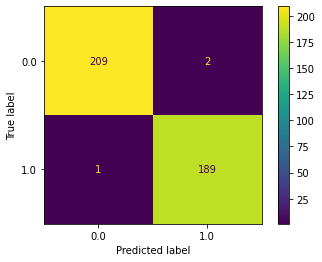

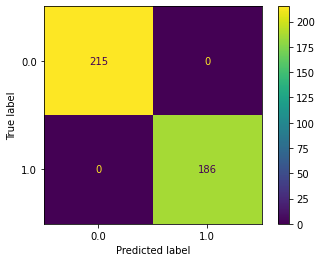

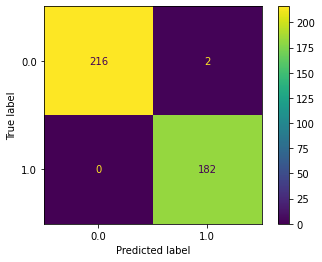

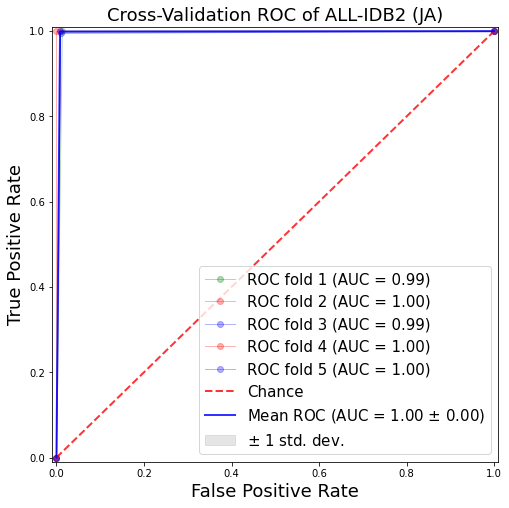

In [4]:
tprs = []
aucs = []
fprs = []
# Define per-fold score containers <-- these are new
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1score_per_fold = []
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(features_ALL_IDB2_Jaya_100iter, labels_ALL_IDB2):
    clf = None
    clf = SVC(kernel='rbf', C=0.1, gamma=0.0001, random_state=0)
    clf.fit(features_ALL_IDB2_Jaya_100iter[train], labels_ALL_IDB2[train])
    preds = clf.predict(features_ALL_IDB2_Jaya_100iter[test])
    precision = precision_score(labels_ALL_IDB2[test], preds)
    recall = recall_score(labels_ALL_IDB2[test], preds)
    accuracy = accuracy_score(labels_ALL_IDB2[test], preds)
    f1 = f1_score(labels_ALL_IDB2[test], preds)
    fpr, tpr, thresholds = roc_curve(labels_ALL_IDB2[test], preds)
    auc_fold = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(auc_fold)
    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1score_per_fold.append(f1)
    print("Fold : ", fold_no, " Accuracy: ", accuracy, " Precision: ", precision, " Recall: ", recall, " F1-Score: ", f1, " AUC: ", auc_fold)
    _ = plot_confusion_matrix(clf, features_ALL_IDB2_Jaya_100iter[test], labels_ALL_IDB2[test])
    print("---------------------------------------------------------")
    fold_no = fold_no + 1

cv5_results_JA_ALL_IDB2_100iter = pd.DataFrame(data={"Accuracy": accuracy_per_fold, "Precision": precision_per_fold, "Recall": recall_per_fold, "F1-Score": f1score_per_fold, " AUC": aucs})
cv5_results_JA_ALL_IDB2_100iter.to_csv("./cv5_results_JA_ALL_IDB2_100iter.csv")
cv5_results_JA_ALL_IDB2_100iter.head()

plt.figure(figsize=(8,8))
plt.plot(fprs[0], tprs[0], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[0]))
plt.plot(fprs[1], tprs[1], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[1]))
plt.plot(fprs[2], tprs[2], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[2]))
plt.plot(fprs[3], tprs[3], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (4, aucs[3]))
plt.plot(fprs[4], tprs[4], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (5, aucs[4]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of ALL-IDB2 (JA)',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

Fold :  1  Accuracy:  0.9950248756218906  Precision:  0.9893617021276596  Recall:  1.0  F1-Score:  0.9946524064171123  AUC:  0.9953703703703703
---------------------------------------------------------
Fold :  2  Accuracy:  1.0  Precision:  1.0  Recall:  1.0  F1-Score:  1.0  AUC:  1.0
---------------------------------------------------------
Fold :  3  Accuracy:  0.9900497512437811  Precision:  0.9770114942528736  Recall:  1.0  F1-Score:  0.9883720930232558  AUC:  0.9913793103448275
---------------------------------------------------------
Fold :  4  Accuracy:  0.9950248756218906  Precision:  0.9905660377358491  Recall:  1.0  F1-Score:  0.9952606635071091  AUC:  0.9947916666666667
---------------------------------------------------------
Fold :  5  Accuracy:  1.0  Precision:  1.0  Recall:  1.0  F1-Score:  1.0  AUC:  1.0
---------------------------------------------------------
Fold :  6  Accuracy:  0.995  Precision:  0.9887640449438202  Recall:  1.0  F1-Score:  0.9943502824858756  AUC:

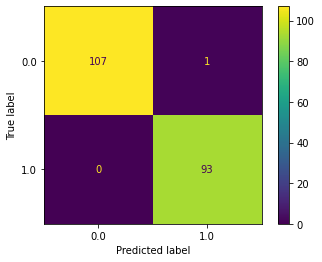

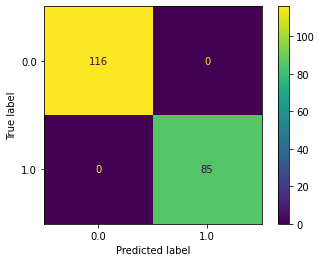

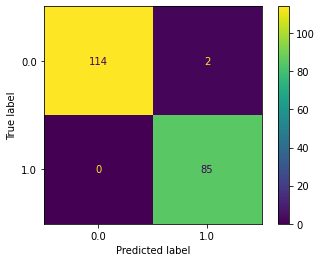

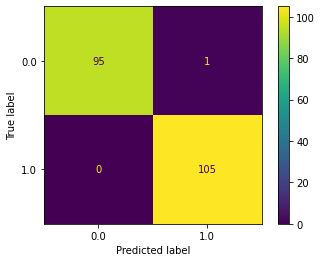

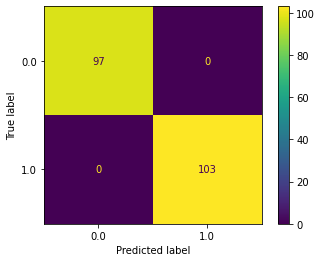

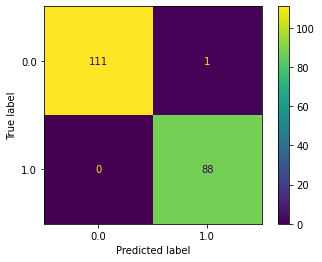

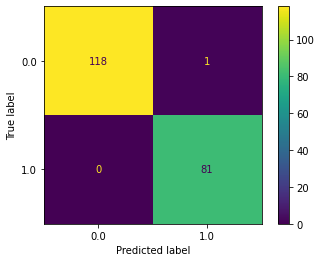

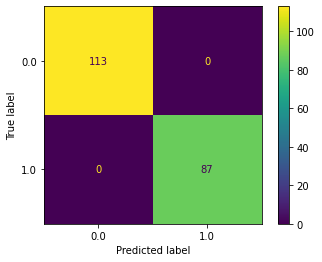

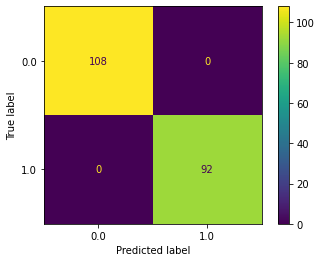

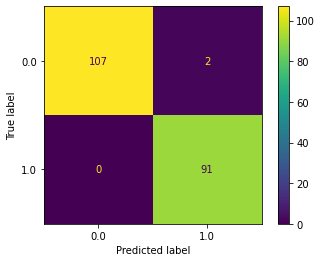

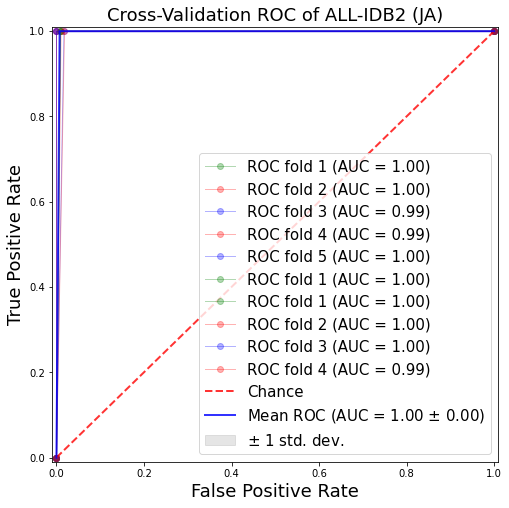

In [5]:
tprs = []
aucs = []
fprs = []
# Define per-fold score containers <-- these are new
accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1score_per_fold = []
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(features_ALL_IDB2_Jaya_100iter, labels_ALL_IDB2):
    clf = None
    clf = SVC(kernel='rbf', C=0.1, gamma=0.0001, random_state=0)
    clf.fit(features_ALL_IDB2_Jaya_100iter[train], labels_ALL_IDB2[train])
    preds = clf.predict(features_ALL_IDB2_Jaya_100iter[test])
    precision = precision_score(labels_ALL_IDB2[test], preds)
    recall = recall_score(labels_ALL_IDB2[test], preds)
    accuracy = accuracy_score(labels_ALL_IDB2[test], preds)
    f1 = f1_score(labels_ALL_IDB2[test], preds)
    fpr, tpr, thresholds = roc_curve(labels_ALL_IDB2[test], preds)
    auc_fold = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(auc_fold)
    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1score_per_fold.append(f1)
    print("Fold : ", fold_no, " Accuracy: ", accuracy, " Precision: ", precision, " Recall: ", recall, " F1-Score: ", f1, " AUC: ", auc_fold)
    _ = plot_confusion_matrix(clf, features_ALL_IDB2_Jaya_100iter[test], labels_ALL_IDB2[test])
    print("---------------------------------------------------------")
    fold_no = fold_no + 1

cv10_results_JA_ALL_IDB2_100iter = pd.DataFrame(data={"Accuracy": accuracy_per_fold, "Precision": precision_per_fold, "Recall": recall_per_fold, "F1-Score": f1score_per_fold, " AUC": aucs})
cv10_results_JA_ALL_IDB2_100iter.to_csv("./cv10_results_JA_ALL_IDB2_100iter.csv")
cv10_results_JA_ALL_IDB2_100iter.head()

plt.figure(figsize=(8,8))
plt.plot(fprs[0], tprs[0], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[0]))
plt.plot(fprs[1], tprs[1], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[1]))
plt.plot(fprs[2], tprs[2], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[2]))
plt.plot(fprs[3], tprs[3], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (4, aucs[3]))
plt.plot(fprs[4], tprs[4], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (5, aucs[4]))
plt.plot(fprs[5], tprs[5], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[5]))
plt.plot(fprs[6], tprs[6], 'g-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (1, aucs[6]))
plt.plot(fprs[7], tprs[7], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (2, aucs[7]))
plt.plot(fprs[8], tprs[8], 'b-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (3, aucs[8]))
plt.plot(fprs[9], tprs[9], 'r-o', lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (4, aucs[9]))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.mean(fprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of ALL-IDB2 (JA)',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()